In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
%matplotlib inline
import os

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt

import pysilcam.postprocess as scpp
import pysilcam.plotting as scplt
from pysilcam.config import PySilcamSettings

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
#datapath = './NEPTUS' # path to folder containing merged NEPTUS logs
datapath = 'Z:/FieldWork/July2019/20190718/Neptuslogs/Merged_logs'
#FOLDER = '250718' # information on mission date used for locating files and understanding times
FOLDER = '180719'

In [3]:
def fix_ctd_time(ctd):
    newtime = []
    for t in ctd[' gmt time']:
        newtime.append(pd.to_datetime(FOLDER[0:2] + '-' + FOLDER[2:4] + '-' + FOLDER[4:6] + t))

    ctd['Time'] = newtime
    return ctd

In [4]:
def extract_middle(stats):
    '''
    Temporary cropping solution due to small window in AUV
    '''
    print('initial stats length:', len(stats))
    r = np.array(((stats['maxr'] - stats['minr'])/2) + stats['minr'])
    c = np.array(((stats['maxc'] - stats['minc'])/2) + stats['minc'])

    points = []
    for i in range(len(c)):
        points.append([(r[i], c[i])])

    pts = np.array(points)
    pts = pts.squeeze()

    # plt.plot(pts[:, 0], pts[:, 1], 'k.')
    # plt.axis('equal')

    ll = np.array([500, 500]) # lower-left
    ur = np.array([1750, 1750])  # upper-right

    inidx = np.all(np.logical_and(ll <= pts, pts <= ur), axis=1)
    inbox = pts[inidx]
    print('inbox shape:', inbox.shape)

    stats = stats[inidx]

    # plt.plot(inbox[:,0], inbox[:,1], 'r.')
    # plt.axis('equal')
    
    print('len stats', len(stats))
    return stats

In [6]:
## Make montages of processed particle images
maxlength = 5000000
minlength = 100
msize = 2048
#roidir = './DATA/' + FOLDER + '/export_backup'
roidir = 'Z:/FieldWork/July2019/20190718'

def montager(stats):
    '''
    Wrapper for pysilcam montage maker
    '''
    stats = stats[~np.isnan(stats['major_axis_length'])]
    stats = stats[(stats['major_axis_length'] *
            settings.PostProcess.pix_size) < maxlength]
    stats = stats[(stats['major_axis_length'] *
            settings.PostProcess.pix_size) > minlength]
    
    stats = stats[stats['Depth'] > 2] # only look for things below 2m depth

#     stats = stats[stats['probability_other']>0.8] # can filter classified probabilities like this

    stats.sort_values(by=['major_axis_length'], ascending=False, inplace=True)
    roifiles = scpp.gen_roifiles(stats, auto_scaler=msize)

    montage = scpp.montage_maker(roifiles, roidir, settings.PostProcess.pix_size, msize, eyecandy=True)
    return montage

In [7]:
# read the ctd data from the exported NEPTUS logs
ctd = pd.read_csv(os.path.join(datapath, FOLDER + '_merged_logs/mra/csv/CTD.csv'), index_col=False)
ctd = fix_ctd_time(ctd) # make the ctd time information useable

FileNotFoundError: File b'./NEPTUS\\250718_merged_logs/mra/csv/CTD.csv' does not exist

In [11]:
def add_latlon_to_stats(stats, time, lat, lon):
    '''This is approximate because lat and lon are treated independently!!!!'''
    sctime = pd.to_datetime(stats['timestamp'])
    # interpolate depths into the SilCam times
    stats['Latitude'] = np.interp(np.float64(sctime), np.float64(time), lat)
    stats['Longitude'] = np.interp(np.float64(sctime), np.float64(time), lon)
    return stats

In [12]:
def silcam_montage_plot(montage, settings):
    scplt.montage_plot(montage, settings.PostProcess.pix_size)

In [13]:
def depth_timeseries_plot(ctd):
    plt.plot(ctd['Time'], ctd[' depth'],'k.', markersize=4)
    plt.ylim(30, 0)
    plt.ylabel('Depth [m]')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=20)
    plt.xticks(horizontalalignment='right')
    #     plt.gcf().autofmt_xdate()

In [14]:
def nd_plot(stats, settings):
    '''Particle number distribution plot'''
    dias, nd = scpp.nd_from_stats_scaled(stats, settings.PostProcess)
    plt.plot(dias, nd, 'k')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(100, 10000)
    plt.xlabel('Equiv. diam. [um]')
    plt.ylabel('Number conc. [#/Arb.Vol./um]')

In [15]:
def map_plot(ctd, request):
    ax = plt.gca()
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(np.arange(9,11,0.05))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

#     ax.set_extent([10.32, 10.45, 63.40, 63.51])
    ax.set_extent([10.3, 10.5, 63.425, 63.5])

    ax.plot(np.array(ctd[' lon (corrected)']), np.array(ctd[' lat (corrected)']),
            'k.', markersize=4, transform=ccrs.Geodetic())
    
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')

    ax.add_image(request, 12)

In [16]:
def summary_figure(ctd, montage, stats, settings):
    '''wrapper for above plotting functions'''
    f = plt.figure(figsize=(12, 12))
    
    request = cimgt.StamenTerrain()
    ax1 = plt.subplot(221, projection=request.crs)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    plt.sca(ax1)
    map_plot(ctd, request)
    plt.title(ctd['Time'].min().strftime('%Y-%m-%d %H:%M') +
              ' - ' +
              ctd['Time'].max().strftime('%Y-%m-%d %H:%M') + 
              '\n' +
              'Max Depth: {:0.0f} [m]'.format(ctd[' depth'].max()) + 
              ' | Raw SilCam images analysed: {:0.0f}'.format(scpp.count_images_in_stats(stats)) + 
              '\n' +
              'Particles analysed: {:0.0f}'.format(len(stats))
             , loc='left')

    plt.sca(ax2)
    depth_timeseries_plot(ctd)

    plt.sca(ax3)
    silcam_montage_plot(montage, settings)

    plt.sca(ax4)
    nd_plot(stats, settings)

In [21]:
# SilCamDataFile = '/media/emlynd/ARCTIC_ABC_A/AILARON/' + FOLDER + '/proc/RAW-STATS.csv' # location of stats file creased from running silcam process (pysilcam)
SilCamDataFile = ('../DATA/' + FOLDER + '/proc_backup/RAW-STATS.csv')

stats = pd.read_csv(SilCamDataFile) # load the stats file
settings = PySilcamSettings('../DATA/config.ini') # load the settings used for processing

stats = extract_middle(stats) # apply temporary (workaround) cropping of stats due to small window

stats = scpp.add_depth_to_stats(stats, ctd['Time'], ctd[' depth']) # merge ctd data into particle stats
stats = add_latlon_to_stats(stats, ctd['Time'], ctd[' lat (corrected)'], ctd[' lon (corrected)']) # merge location data into particle stats

montage = montager(stats) # make a montage of particle images

initial stats length: 144000


C:\ProgramData\anaconda3\envs\ayasilcam\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in less_equal


inbox shape: (16289, 2)
len stats 16289
rofiles: 11820
reducing particles by factor of 6
rofiles: 1970
making a montage - this might take some time....


100%|████████████████████████████████████████████████████████████████████| 1970/1970 [01:58<00:00, 16.60it/s]


montage complete


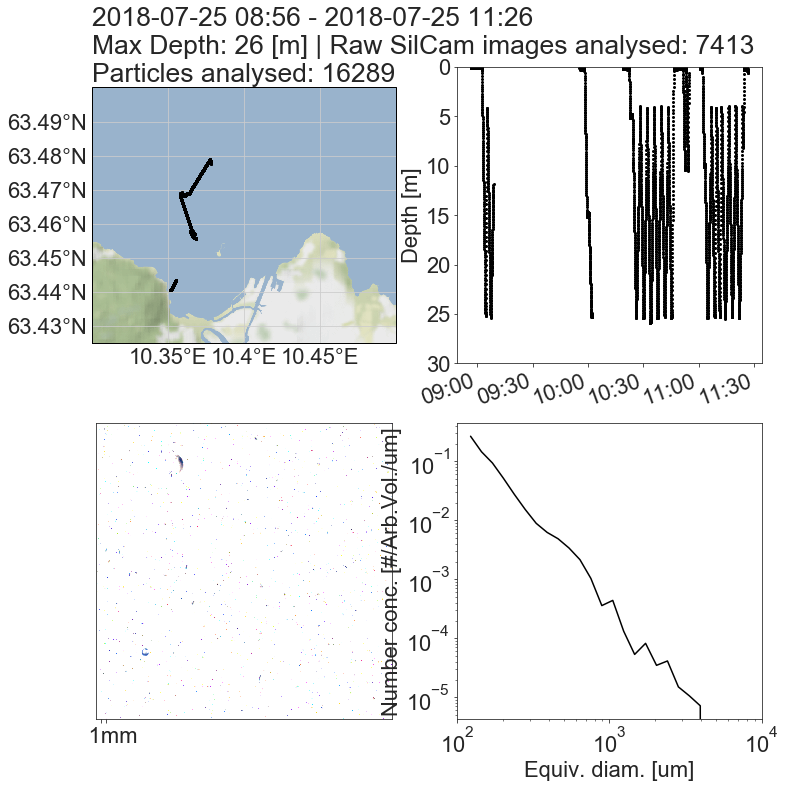

In [25]:
summary_figure(ctd, montage, stats, settings) # make a summary figure
# plt.savefig('figs/' + FOLDER + '.png', dpi=600, bbox_inches='tight')

particle index                                          5
major_axis_length                                 198.678
minor_axis_length                                 18.9181
equivalent_diameter                               30.7988
solidity                                         0.243067
minr                                                 1620
minc                                                 1477
maxr                                                 1765
maxc                                                 1588
probability_oil                               2.23361e-12
probability_other                             6.23703e-11
probability_bubble                                      1
probability_faecal_pellets                    2.03834e-25
probability_copepod                           5.25725e-19
probability_diatom_chain                       2.5493e-21
probability_oily_gas                          6.97761e-17
export name                   D20180725T104648.689708-PN5
timestamp     

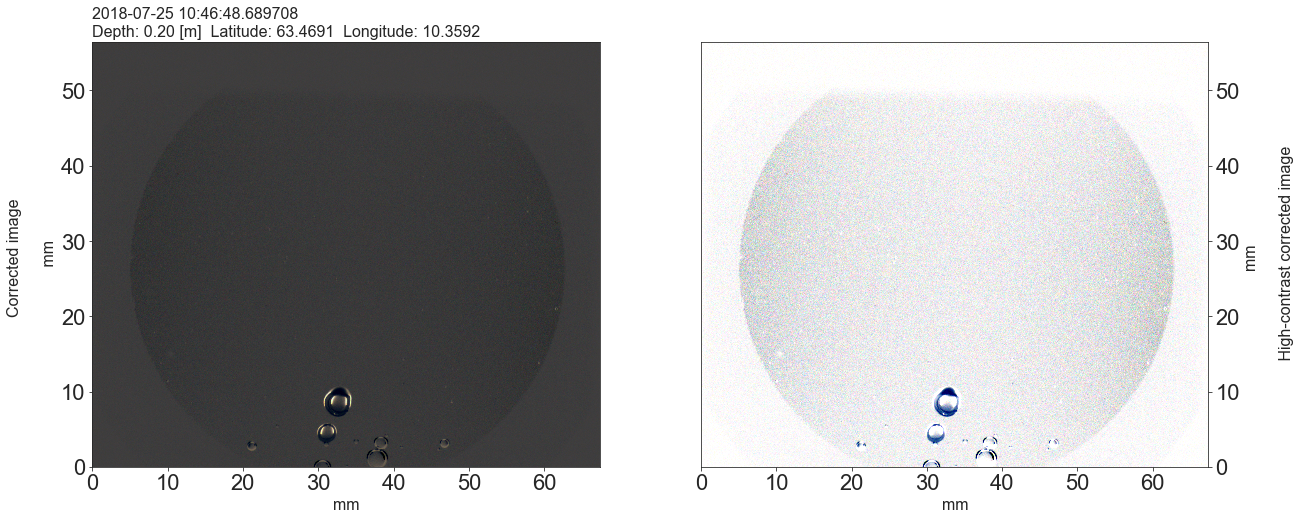

In [28]:
## Example of visualising individual iamges

from pysilcam.background import correct_im_accurate
import matplotlib
font = {'size'   : 22}
matplotlib.rc('font', **font)

# use the processed stats file from pysilcam (silcam process) to extract the nt longest particle in the dataset
info = scpp.extract_nth_longest(stats, settings, n=1)
print(info) # print the information about the particle
filename = info['export name'][0:-4] + '.silc' # obtain filename of raw image of interest

# location of unprocessed silc files
RAWDIR = '../DATA/250718/RAW/'

# select an empty iamge that could be used as a clean background (just for this viusalisation)
bgname = 'D20180725T102153.904145.silc' #''' D20180726T100127.438212.silc'''

imbg = np.load(os.path.join(RAWDIR, bgname)) # load the background silc file

imraw = np.load(os.path.join(RAWDIR, filename)) # load the raw image of interest (selected automatically above)

imc = correct_im_accurate(imbg, imraw) # apply background correction

# plotting
f, a = plt.subplots(1,2, figsize=(20,12))

plt.sca(a[0])
scplt.show_imc(imc, mag=1) # if you use this function for LAUV data, always specify mag=1
plt.title(info['timestamp'] + '\n' + 'Depth: {:0.2f} [m]  '.format(info['Depth']) + 
          'Latitude: {:0.4f}  Longitude: {:0.4f}'.format(info['Latitude'], info['Longitude']),
          loc='left', fontsize=16)
plt.xlabel('mm', fontsize=16)
plt.ylabel('Corrected image \n\n mm', fontsize=16)

plt.sca(a[1])
scplt.show_imc(scpp.explode_contrast(imc), mag=1) # show an example with increased contract
plt.xlabel('mm', fontsize=16)
plt.ylabel('mm \n\n High-contrast corrected image', fontsize=16)
plt.gca().yaxis.tick_right()
plt.gca().yaxis.set_label_position("right")

# plt.savefig('figs/tentacle.png', dpi=300, bbox_inches='tight')